## Imports

In [1]:
from tinygrad import nn, Tensor, TinyJit
from tinygrad.nn.datasets import mnist
import cv2
from IPython.display import display
import numpy as np
from PIL import Image

X_train, Y_train, X_test, Y_test = mnist()
X_train, Y_train, X_test, Y_test = X_train/255.0, Y_train, X_test/255.0, Y_test
X_pred = X_test.reshape(X_test.shape[0], 784)

## Model

In [2]:
latent_size = 9

class Encoder:
    def __init__(self):
        self.l1 = nn.Linear(784, 128)
        self.b1 = nn.BatchNorm(128)
        self.l2 = nn.Linear(128, latent_size)
        self.b2 = nn.BatchNorm(latent_size)
        self.l3 = nn.Linear(latent_size, latent_size)
        
    def __call__(self, x:Tensor) -> Tensor:
        x = self.l1(x).relu()
        x = self.l2(self.b1(x)).relu()
        return self.l3(self.b2(x)).sigmoid()

class Decoder:
    def __init__(self):
        self.l1 = nn.Linear(latent_size, latent_size)
        self.b1 = nn.BatchNorm(latent_size)
        self.l2 = nn.Linear(latent_size, 128)
        self.b2 = nn.BatchNorm(128)
        self.l3 = nn.Linear(128, 784)
        
    def __call__(self, x:Tensor) -> Tensor:
        x = self.l1(x).relu()
        x = self.l2(self.b1(x)).relu()
        return self.l3(self.b2(x)).sigmoid()
    
class Model:
    def __init__(self, enco, deco):
        self.encoder = enco
        self.decoder = deco
        
    def __call__(self, x:Tensor) -> Tensor:
        latent = self.encoder(x)
        final = self.decoder(latent)
        return final

encoder = Encoder()
decoder = Decoder()
model = Model(encoder, decoder)

## Train

In [3]:
prediction_history = []
optim = nn.optim.Adam(nn.state.get_parameters(model))
batch_size = 256

@TinyJit
@Tensor.train()
def train_step() -> Tensor:
    Tensor.training = True
    samples = Tensor.randint(batch_size, high=X_train.shape[0])
    X = X_train[samples]
    X = X.reshape(batch_size, 784)
    optim.zero_grad()
    loss = model(X).binary_crossentropy(X).backward()
    optim.step()
    return loss

for step in range(300):
    loss = train_step()
    Tensor.training = False
    if step%100 == 0:
        print(f"step {step:4d}, loss {loss.item():.2f}")
    if step%3 == 0:
        prediction_history.append(model(X_pred).numpy())

step    0, loss 0.73
step  100, loss 0.33
step  200, loss 0.21


## Show a Result

In [4]:
i = 0
sample = Tensor.full((1), i)
Tensor.training = False
model_input = X_test[sample].reshape(sample.shape[0], 784)
output = model(model_input).numpy()*255.0
latent_space = encoder(model_input)
result = decoder(latent_space)
result_255 = result.numpy()*255.0
reshaped = result_255.reshape(28, 28)
int_array = reshaped.astype(np.uint8)
final_result = Image.fromarray(int_array)

display(final_result)

colored_img = cv2.applyColorMap(int_array, cv2.COLORMAP_VIRIDIS)
rgb = cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB)
thisimg = Image.fromarray(rgb)

display(thisimg)

## Tiles Training History

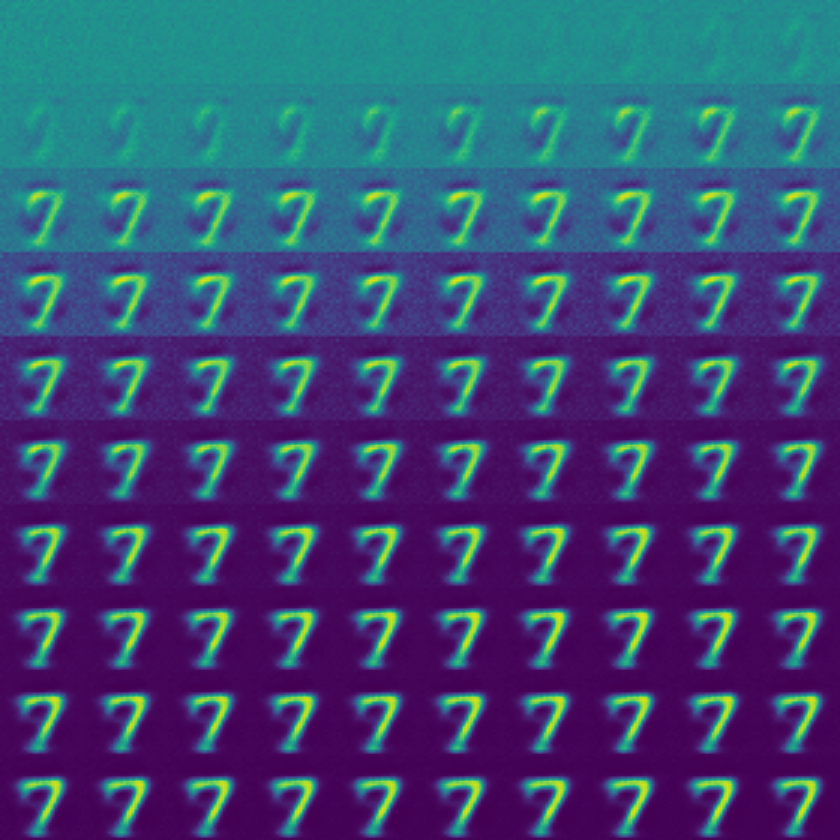

In [5]:
idx = 0
splits = 10
blends = np.zeros(shape=(28 * splits, 28 * splits))
for i in range(splits):
    for j in range(splits):
        this_img = prediction_history[i * splits + j][idx]
        blends[i*28:(i+1)*28, j*28:(j+1)*28] = this_img.reshape(28, 28)
        
blends = blends * 255.0
blends = blends.astype(np.uint8)
blends = cv2.resize(blends, (0, 0), fx=3, fy=3)
        
colored_img = cv2.applyColorMap(blends, cv2.COLORMAP_VIRIDIS)
rgb = cv2.cvtColor(colored_img, cv2.COLOR_BGR2RGB)
img_resize = Image.fromarray(rgb)
img_resize.save('train_history.png')

display(img_resize)

In [6]:
idx = 0
pred_numpy_array = np.array(prediction_history)
pred_numpy_array *= 255
pred_numpy_array = pred_numpy_array.astype(np.uint8)
pil_img = Image.fromarray(pred_numpy_array[99][idx].reshape(28, 28))

display(pil_img)

ims = [Image.fromarray(pred_numpy_array[i][idx].reshape(28, 28)[:,:]) for i in range(99)]

ims[0].save('single_digit.gif', save_all=True, append_images=ims[1:], loop=0, duration=50)